In [5]:
!pip install xgboost --quiet

import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    average_precision_score,
)
from collections import Counter
import itertools
import pickle

print("Setup complete ✅")


Setup complete ✅


In [6]:
df = pd.read_csv('loan_default.csv')

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop any rows with missing values (very few in this dataset)
print("\nDropping rows with any missing values...")
rows_before = df.shape[0]
df = df.dropna()
rows_after = df.shape[0]

print(f"Rows before: {rows_before}, after dropping NAs: {rows_after}")
print("Data shape after dropping NAs:", df.shape)


Data shape: (255347, 18)
Columns: ['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']

Missing values per column:
LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

Dropping rows with any missing values...
Rows before: 255347, after dropping NAs: 255347
Data shape after dropping NAs: (255347, 18)


In [7]:
# 3.1 Drop ID-like columns that shouldn't be used as features
id_cols = ['LoanID', 'loan_id', 'ID', 'id']
df = df.drop(columns=[c for c in id_cols if c in df.columns])

# 3.2 Map binary string features to 0/1
binary_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']

for col in binary_cols:
    if col in df.columns:
        # If it's already boolean True/False, convert directly to 1/0
        if df[col].dtype == bool:
            df[col] = df[col].astype(int)
        else:
            # Normalize to uppercase strings, then map YES/NO to 1/0
            df[col] = (
                df[col]
                .astype(str)
                .str.strip()
                .str.upper()
                .map({'YES': 1, 'NO': 0})
            )

# 3.3 Define categorical features list (only keep those that exist)
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
categorical_features = [c for c in categorical_features if c in df.columns]

# 3.4 Define numeric & categorical columns (for robustness if you change dataset)
num_cols = df.select_dtypes(include=['int64', 'float64', 'bool']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# (We already dropped NAs, but this keeps code robust if you reuse it)
if len(num_cols) > 0:
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

if len(cat_cols) > 0:
    df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# 3.5 One-hot encode main categorical features
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# 3.6 Separate features (X) and target (y)
TARGET_COL = 'Default'

if TARGET_COL not in df_encoded.columns:
    raise ValueError(
        f"Target column '{TARGET_COL}' not found. "
        f"Available columns: {df_encoded.columns.tolist()}"
    )

X = df_encoded.drop(TARGET_COL, axis=1)
y = df_encoded[TARGET_COL]

# 3.7 Ensure all feature columns are numeric (required by XGBoost)
non_numeric_cols = X.select_dtypes(exclude=['number', 'bool']).columns
if len(non_numeric_cols) > 0:
    print("\nEncoding non-numeric feature columns as category codes:", list(non_numeric_cols))
    for col in non_numeric_cols:
        X[col] = X[col].astype('category').cat.codes

print("\nFeature dtypes after preprocessing:")
print(X.dtypes.value_counts())

print("\nFinal feature matrix shape:", X.shape)
print("Target distribution:", y.value_counts().to_dict())



Feature dtypes after preprocessing:
bool       12
int64      10
float64     2
Name: count, dtype: int64

Final feature matrix shape: (255347, 24)
Target distribution: {0: 225694, 1: 29653}


In [8]:
# 4.1 First split: Train+Val vs Test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4.2 Second split: Train vs Validation (from Train+Val)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,          # 0.25 of 0.8 = 0.20 of full data
    random_state=42,
    stratify=y_trainval
)

print("Train shape    :", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape     :", X_test.shape)

# 4.3 Class distribution and scale_pos_weight from TRAIN ONLY
counter_full = Counter(y)
counter_train = Counter(y_train)

print("\nClass distribution (full dataset):", counter_full)
print("Class distribution (train only)  :", counter_train)

neg, pos = counter_train[0], counter_train[1]
scale_pos_weight = neg / pos
print("scale_pos_weight (train only):", scale_pos_weight)


Train shape    : (153207, 24)
Validation shape: (51070, 24)
Test shape     : (51070, 24)

Class distribution (full dataset): Counter({0: 225694, 1: 29653})
Class distribution (train only)  : Counter({0: 135416, 1: 17791})
scale_pos_weight (train only): 7.611488955089652


In [9]:
from sklearn.metrics import roc_auc_score, average_precision_score

# 5.1 Define a small hyperparameter grid
param_grid = {
    "max_depth":        [3, 4, 5],
    "min_child_weight": [1, 5],
    "subsample":        [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "learning_rate":    [0.05, 0.1],
}

# Create list of param combinations
import itertools
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total hyperparameter combinations to test: {len(param_combinations)}")

best_val_pr_auc = -np.inf
best_val_roc_auc = -np.inf
best_model = None
best_params = None

# 5.2 Loop over hyperparameter combinations
for i, params in enumerate(param_combinations, start=1):
    print(f"\n=== Training model {i}/{len(param_combinations)} with params: {params} ===")

    model = xgb.XGBClassifier(
        n_estimators=1000,          # large; early stopping will pick the effective number
        random_state=42,
        eval_metric='aucpr',        # focus early stopping on PR-AUC
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        early_stopping_rounds=30,
        **params
    )

    eval_set = [(X_train, y_train), (X_val, y_val)]

    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False
    )

    # Predict probabilities on validation set
    y_val_proba = model.predict_proba(X_val)[:, 1]

    # Compute validation ROC-AUC and PR-AUC
    roc_auc_val = roc_auc_score(y_val, y_val_proba)
    pr_auc_val  = average_precision_score(y_val, y_val_proba)

    print(f"  -> Validation ROC-AUC: {roc_auc_val:.4f}")
    print(f"  -> Validation PR-AUC : {pr_auc_val:.4f}")
    print(f"  -> Best iteration used: {model.best_iteration}")

    # Use PR-AUC as primary ranking metric for imbalanced credit risk
    if pr_auc_val > best_val_pr_auc:
        best_val_pr_auc = pr_auc_val
        best_val_roc_auc = roc_auc_val
        best_model = model
        best_params = params

print("\n=== Hyperparameter search complete ===")
print("Best validation PR-AUC :", best_val_pr_auc)
print("Best validation ROC-AUC:", best_val_roc_auc)
print("Best hyperparameters   :", best_params)


Total hyperparameter combinations to test: 48

=== Training model 1/48 with params: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.05} ===
  -> Validation ROC-AUC: 0.7528
  -> Validation PR-AUC : 0.3222
  -> Best iteration used: 378

=== Training model 2/48 with params: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.1} ===
  -> Validation ROC-AUC: 0.7526
  -> Validation PR-AUC : 0.3216
  -> Best iteration used: 166

=== Training model 3/48 with params: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'learning_rate': 0.05} ===
  -> Validation ROC-AUC: 0.7532
  -> Validation PR-AUC : 0.3221
  -> Best iteration used: 340

=== Training model 4/48 with params: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'learning_rate': 0.1} ===
  -> Validation ROC-AUC: 0.7528
  -> Validation PR-AUC : 0.3222
  -> Best iteratio

In [10]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

# 6.1 Retrain best model on TRAIN+VALIDATION with best hyperparameters
print("\nRetraining best model on TRAIN+VALIDATION with best hyperparameters...")

# Extract parameters from best_params and other model settings
params_for_train = {
    **best_params,
    'objective': 'binary:logistic', # Default for XGBClassifier for binary classification
    'eval_metric': 'aucpr', # For monitoring
    'seed': 42,
    'nthread': -1, # Corresponds to n_jobs=-1
    'scale_pos_weight': scale_pos_weight
}

# Create DMatrix objects
dtrainval = xgb.DMatrix(X_trainval, label=y_trainval)
dtest = xgb.DMatrix(X_test, label=y_test)

evals_result_final = {}

final_bst = xgb.train(
    params=params_for_train,
    dtrain=dtrainval,
    num_boost_round=1000, # Max iterations
    evals=[(dtrainval, 'train'), (dtest, 'test')],
    evals_result=evals_result_final,
    early_stopping_rounds=30,
    verbose_eval=False
)

# Assign the trained Booster to a dummy XGBClassifier for easier predict_proba usage
final_model = xgb.XGBClassifier(**best_params) # Re-init just for the wrapper structure
final_model._Booster = final_bst
# The best_iteration is available directly from final_bst, no need to set it on final_model

print("Final training complete ✅")
print("Final best iteration:", final_bst.best_iteration)

# 6.2 Evaluate ranking quality on TEST set
# Directly use the booster object for predictions when objective is binary:logistic
y_test_proba = final_bst.predict(dtest, iteration_range=(0, final_bst.best_iteration))

roc_auc_test = roc_auc_score(y_test, y_test_proba)
pr_auc_test  = average_precision_score(y_test, y_test_proba)

gini_test = 2 * roc_auc_test - 1

print(f"\n=== TEST RANKING PERFORMANCE (no threshold) ===")
print(f"ROC-AUC : {roc_auc_test:.4f}")
print(f"PR-AUC  : {pr_auc_test:.4f}")
print(f"Gini    : {gini_test:.4f}")



Retraining best model on TRAIN+VALIDATION with best hyperparameters...
Final training complete ✅
Final best iteration: 215

=== TEST RANKING PERFORMANCE (no threshold) ===
ROC-AUC : 0.7586
PR-AUC  : 0.3315
Gini    : 0.5172


Plotting learning curve...


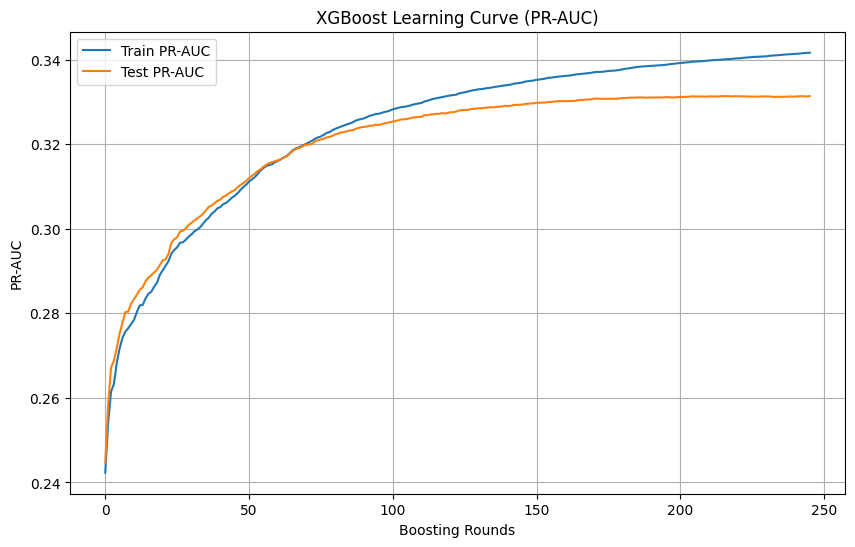

Learning curve plot generated ✅


In [11]:
print('Plotting learning curve...')

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(evals_result_final['train']['aucpr'], label='Train PR-AUC')
plt.plot(evals_result_final['test']['aucpr'], label='Test PR-AUC')
plt.xlabel('Boosting Rounds')
plt.ylabel('PR-AUC')
plt.title('XGBoost Learning Curve (PR-AUC)')
plt.legend()
plt.grid(True)
plt.show()

print('Learning curve plot generated ✅')


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# analyse many thresholds on the TEST set
thresholds = np.linspace(0.1, 0.9, 81)

results = []

# Define cost weights for FN and FP
C_FN = 10  # cost of missing a defaulter
C_FP = 1   # cost of flagging a good customer

for thr in thresholds:
    y_pred = (y_test_proba >= thr).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Recall for class 0 (specificity) and class 1
    rec0 = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    rec1 = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    bal_acc = 0.5 * (rec0 + rec1)

    # Simple cost function
    cost = C_FN * fn + C_FP * fp

    results.append({
        "threshold": thr,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "balanced_accuracy": bal_acc,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "cost": cost,
    })

results_df = pd.DataFrame(results)

# Find interesting operating points
idx_acc   = results_df["accuracy"].idxmax()
idx_f1    = results_df["f1"].idxmax()
idx_bal   = results_df["balanced_accuracy"].idxmax()
idx_cost  = results_df["cost"].idxmin()


candidates_high_recall = results_df[results_df["recall"] >= 0.6]
if not candidates_high_recall.empty:
    idx_highrec = candidates_high_recall["accuracy"].idxmax()
else:
    idx_highrec = None

summary_rows = []

summary_rows.append({"scenario": "max_accuracy", **results_df.loc[idx_acc].to_dict()})
summary_rows.append({"scenario": "max_f1", **results_df.loc[idx_f1].to_dict()})
summary_rows.append({"scenario": "max_balanced_accuracy", **results_df.loc[idx_bal].to_dict()})
summary_rows.append({"scenario": f"min_cost_FN{C_FN}_FP{C_FP}", **results_df.loc[idx_cost].to_dict()})

if idx_highrec is not None:
    summary_rows.append({"scenario": "recall>=0.60_max_accuracy", **results_df.loc[idx_highrec].to_dict()})

summary_df = pd.DataFrame(summary_rows)

print("\n=== Key Threshold Scenarios on TEST Set ===")
display(summary_df[[
    "scenario", "threshold", "accuracy", "precision", "recall",
    "f1", "balanced_accuracy", "tn", "fp", "fn", "tp", "cost"
]])



=== Key Threshold Scenarios on TEST Set ===


,scenario,threshold,accuracy,precision,recall,f1,balanced_accuracy,tn,fp,fn,tp,cost
0,max_accuracy,0.86,0.886861,0.616438,0.068285,0.122951,0.531351,44887.0,252.0,5526.0,405.0,55512.0
1,max_f1,0.62,0.804151,0.297281,0.503288,0.373779,0.673485,38083.0,7056.0,2946.0,2985.0,36516.0
2,max_balanced_accuracy,0.54,0.734658,0.247983,0.632103,0.356216,0.690118,33770.0,11369.0,2182.0,3749.0,33189.0
3,min_cost_FN10_FP1,0.43,0.608087,0.198931,0.784522,0.317383,0.684713,26402.0,18737.0,1278.0,4653.0,31517.0
4,recall>=0.60_max_accuracy,0.56,0.754318,0.259698,0.602765,0.362999,0.688498,34948.0,10191.0,2356.0,3575.0,33751.0


In [14]:
# Pick one "default" threshold for deployment, e.g. the cost-minimizing one
default_thr = summary_df.loc[summary_df["scenario"] == f"min_cost_FN{C_FN}_FP{C_FP}", "threshold"].values[0]

artifact = {
    "model": final_model,
    "feature_names": X.columns.tolist(),
    "best_params": best_params,
    "ranking_metrics_test": {
        "roc_auc": float(roc_auc_test),
        "pr_auc": float(pr_auc_test),
        "gini": float(gini_test),
    },
    "threshold_scenarios": summary_df.to_dict(orient="records"),
    "default_threshold": float(default_thr),
    "C_FN": C_FN,
    "C_FP": C_FP,
}

with open('xgboost_loan_default_research.pkl', 'wb') as f:
    pickle.dump(artifact, f)

print("\nResearch artifact saved as 'xgboost_loan_default_research.pkl' ✅")
print("Default threshold (cost-based):", default_thr)



Research artifact saved as 'xgboost_loan_default_research.pkl' ✅
Default threshold (cost-based): 0.43000000000000005


In [15]:
display(summary_df[[    "scenario", "threshold", "accuracy", "precision", "recall",    "f1", "balanced_accuracy", "tn", "fp", "fn", "tp", "cost" ]])

,scenario,threshold,accuracy,precision,recall,f1,balanced_accuracy,tn,fp,fn,tp,cost
0,max_accuracy,0.86,0.886861,0.616438,0.068285,0.122951,0.531351,44887.0,252.0,5526.0,405.0,55512.0
1,max_f1,0.62,0.804151,0.297281,0.503288,0.373779,0.673485,38083.0,7056.0,2946.0,2985.0,36516.0
2,max_balanced_accuracy,0.54,0.734658,0.247983,0.632103,0.356216,0.690118,33770.0,11369.0,2182.0,3749.0,33189.0
3,min_cost_FN10_FP1,0.43,0.608087,0.198931,0.784522,0.317383,0.684713,26402.0,18737.0,1278.0,4653.0,31517.0
4,recall>=0.60_max_accuracy,0.56,0.754318,0.259698,0.602765,0.362999,0.688498,34948.0,10191.0,2356.0,3575.0,33751.0
